# **<font color="blue">Анализ бизнес-показателей развлекательного приложения </font>**

### Описание проекта

- **<font color="green">Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. В чем причина?</font>**

### Цель проекта

- **<font color="green">Выявить причины убытков компании при огромных вложениях. Дать рекомендацию</font>**

### Описание данных

- *Таблица visits_log_short (лог сервера с информацией о посещениях сайта):*

    User Id — уникальный идентификатор пользователя\
    Device — категория устройства пользователя\
    Session start — дата и время начала сессии\
    Session End — дата и время окончания сессии\
    Channel — идентификатор рекламного источника, из которого пришел пользователь\
    Region - страна пользователя\
    

- *Таблица orders_log_short (информация о заказах):*

    User Id — уникальный id пользователя, который сделал заказ\
    Event Dt — дата и время покупки\
    Revenue — выручка\
    

- *Таблица costs_short (информация о затратах на маркетинг):*

    Channel — идентификатор рекламного источника\
    Dt — дата\
    Costs — затраты на этот рекламный источник в этот день\

### Последовательность шагов проекта

- Шаг 1. Загрузка данных и подготовка их к анализу
- Шаг 2. Написание функции для расчета и анализа LTV, ROI, удержания и конверсии
- Шаг 3. Проведение исследовательского анализа данных
- Шаг 4. Маркетинг
- Шаг 5. Оценка окупаемость рекламы

## Изучение данных

- ***Импортируем библиотеки***

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt 

- ***Загрузим данные***

In [2]:
import os
if os.path.exists('visits_info_short.csv'):
    visits = pd.read_csv('visits_info_short.csv') # локальный путь
else:
    visits = pd.read_csv('/datasets/visits_info_short.csv') # путь указанный в проекте
    
if os.path.exists('orders_info_short.csv'):
    orders = pd.read_csv('orders_info_short.csv') # локальный путь
else:
    orders = pd.read_csv('/datasets/orders_info_short.csv') # путь указанный в проекте
    
if os.path.exists('costs_info_short.csv'):
    costs = pd.read_csv('costs_info_short.csv') # локальный путь
else:
    costs = pd.read_csv('/datasets/costs_info_short.csv') # путь указанный в проекте    

In [3]:
visits.sample(5)

,User Id,Region,Device,Channel,Session Start,Session End
15525,535466172896,United States,iPhone,FaceBoom,2019-05-17 04:34:55,2019-05-17 04:35:37
13276,212038843391,United States,Mac,RocketSuperAds,2019-05-15 04:34:41,2019-05-15 05:29:11
57803,756952867174,United States,iPhone,TipTop,2019-06-29 05:09:04,2019-06-29 06:29:20
95519,700593261515,United States,iPhone,FaceBoom,2019-08-03 16:56:46,2019-08-03 17:30:53
157664,96549430607,United States,Android,TipTop,2019-09-24 20:35:41,2019-09-24 20:42:30


In [4]:
orders.sample(5)

,User Id,Event Dt,Revenue
35007,545535642987,2019-09-07 04:17:16,4.99
9925,263301777386,2019-07-29 09:01:46,4.99
31143,521189493251,2019-07-16 03:21:34,4.99
19808,995577721582,2019-09-24 08:42:28,4.99
37832,160882867841,2019-10-08 06:00:10,4.99


In [5]:
costs.sample(5)

,dt,Channel,costs
70,2019-07-10,FaceBoom,156.20
967,2019-07-07,AdNonSense,19.95
44,2019-06-14,FaceBoom,163.90
872,2019-09-30,YRabbit,5.04
1147,2019-07-07,LeapBob,9.45


***Вывод***

<div style="border:solid indigo 1px; padding: 20px">
    

- Необходимо изменить названия колонок: перевести к нижнему регистру и заменить пробел между слов на '_'

***Напишем функцию для:***
- перевода названий к нижнему регистру
- замена пробела в названии на '_'

In [6]:
def change_name_column(df):
    df.columns = [x.lower() for x in df.columns]
    df.columns = [x.replace(' ','_') for x in df.columns]

In [7]:
change_name_column(visits)

In [8]:
change_name_column(orders)

In [9]:
change_name_column(costs)

- ***Проверим типы данных***

In [10]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
user_id          309901 non-null int64
region           309901 non-null object
device           309901 non-null object
channel          309901 non-null object
session_start    309901 non-null object
session_end      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
user_id     40212 non-null int64
event_dt    40212 non-null object
revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.5+ KB


In [12]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


***Вывод***

<div style="border:solid indigo 1px; padding: 20px">
    

- Необходимо привести даты к типу datetime

In [13]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

- ***Проверим датафреймы на наличие дубликатов***

In [14]:
visits.duplicated().sum()

0

In [15]:
orders.duplicated().sum()

0

In [16]:
costs.duplicated().sum()

0

- ***Проверим датафреймы на наличие пропусков***

In [17]:
round((visits.isna().mean()*100),2)

user_id          0.0
region           0.0
device           0.0
channel          0.0
session_start    0.0
session_end      0.0
dtype: float64

In [18]:
round((orders.isna().mean()*100),2)

user_id     0.0
event_dt    0.0
revenue     0.0
dtype: float64

In [19]:
round((costs.isna().mean()*100),2)

dt         0.0
channel    0.0
costs      0.0
dtype: float64

### Вывод

<div style="border:solid indigo 2px; padding: 20px">

**После загрузки данных исправили следующие моменты:**

- названия колонок перевели к нижнему регистру и заменили пробелы в названии на '_'
- привели тип данных с датами к datetime
    
**Пропусков в данных нет**

**Дубликатов в данных нет**

##  Функции для расчета и анализа LTV, ROI, удержания и конверсии

 - ***Зададим функции для создания пользовательских профилей, расчета и анализа LTV, ROI, удержания и конверсии***

In [20]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    '''for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )'''

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [21]:
# функция для расчёта удержания
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [22]:
# функция для расчёта конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [23]:
#функция для визуализации удержания
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    #retention.query('payer == True').droplevel('payer').T.plot(
    retention.query('payer == True').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    #retention.query('payer == False').droplevel('payer').T.plot(
    retention.query('payer == False').T.plot(    
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [24]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

- ***Загрузим функции для визуализации этих метрик — filter_data(), plot_retention(), plot_conversion() и plot_ltv_roi()***

In [25]:
# функция для сглаживания фрейма
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [26]:
# функция для визуализации конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [27]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

##  Исследовательский анализ данных

- ***Получим профили пользователей.***

Для этого вызовем функцию get_profiles(), передав ей данные о посещениях, покупках, тратах на рекламу.

In [28]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


### Определим минимальную и максимальную дату привлечения пользователей


In [29]:
observation_date = datetime(2019,11,1).date()

In [30]:
min_analysis_date = profiles['first_ts'].min().date()
min_analysis_date

datetime.date(2019, 5, 1)

In [31]:
max_analysis_date = profiles['first_ts'].max().date()
max_analysis_date

datetime.date(2019, 10, 27)

- ***По заданию пользователи должны окупаться не позднее чем через две недели после привлечения***

In [32]:
horizon_days = 14

#### Вывод

In [33]:
print(f'Получили следующие данные:' '\n' '\n'
      f'Минимальная дата анализа - {min_analysis_date}' '\n'
      f'Момент анализа - {observation_date}' '\n'
      f'Горизонт анализа - {horizon_days}' '\n'
      f'Максимальная дата анализа - {max_analysis_date}' '\n')

Получили следующие данные:

Минимальная дата анализа - 2019-05-01
Момент анализа - 2019-11-01
Горизонт анализа - 14
Максимальная дата анализа - 2019-10-27



### Изучим из каких стран приходят посетители. Какие страны дают больше всего платящих пользователей.

- ***Напишем функции для группировки профиля по определенному параметру и фактору платежей***

In [34]:
def profiles_sm(groupby):
    return (profiles
            .groupby([groupby])
            .agg({'user_id':'count'})
            .sort_values(['user_id'], ascending=False)
            .reset_index()
      )

In [35]:
def profiles_sm_payer(groupby):
    return (profiles
            .query('payer == True')
            .groupby([groupby])
            .agg({'user_id':'count'})
            .sort_values(['user_id'], ascending=False)
            .reset_index()
      )

In [36]:
profiles_region = profiles_sm('region')
profiles_region

,region,user_id
0,United States,100002
1,UK,17575
2,France,17450
3,Germany,14981


- ***Напишем функцию для построения графика посетителей***

In [37]:
def graph(height,x_pos, xlabel, ylabel, title, color, rotation):
    height = list(height)
    x_pos = list(x_pos)
    plt.figure(figsize=(14,3))
    plt.bar(x_pos, height, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=rotation) 
    
    def autolabel(rects, labels=None, height_factor=0.01):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            if labels is not None:
                try:
                    label = labels[i]
                except (TypeError, KeyError):
                    label = ' '
            else:
                label = '%d' % int(height)
            ax.text(rect.get_x() + rect.get_width()/2., height_factor*height,
                    '{}'.format(label),
                    ha='center', va='bottom')

    ax = plt.gca()
    autolabel(ax.patches, height_factor=0.85)

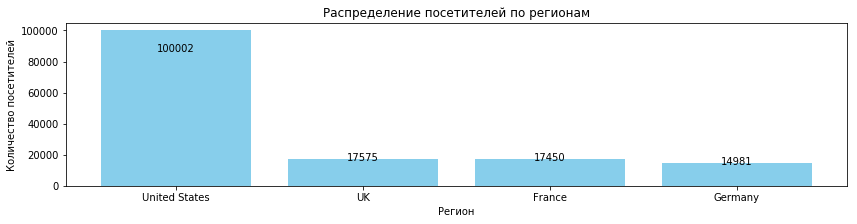

In [38]:
graph(profiles_region['user_id'],
      profiles_region['region'],
      'Регион',
      'Количество посетителей',
      'Распределение посетителей по регионам',
      'skyblue',
       0)

- ***Найдем распределение платящих пользователей по регионам.***

In [39]:
profiles_region_payer = profiles_sm_payer('region')
profiles_region_payer=profiles_region_payer.merge(profiles_region,
                                                  how='left',
                                                  on='region')
profiles_region_payer.columns=['region', 'count_payer', 'count_all']
profiles_region_payer['part_of_paying'] = (profiles_region_payer['count_payer'] / profiles_region_payer['count_all']).map(lambda x: '{:,.1%}'.format(x))
profiles_region_payer 

,region,count_payer,count_all,part_of_paying
0,United States,6902,100002,6.9%
1,UK,700,17575,4.0%
2,France,663,17450,3.8%
3,Germany,616,14981,4.1%


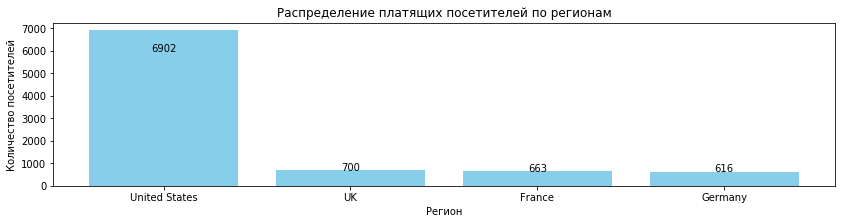

In [40]:
graph(profiles_region_payer['count_payer'],
      profiles_region_payer['region'],
      'Регион',
      'Количество посетителей',
      'Распределение платящих посетителей по регионам',
      'skyblue',
       0)

#### Вывод

<div style="border:solid indigo 2px; padding: 20px">

**Регион пользователей**
- Самый главный поставщик пользователей -  United States 100 000 
- Далее идет UK  17 575. Почти в 6 раз меньше, чем у United States.
- 3 и 4 места France и Germany.

**Регион с большим количеством платящих пользователей**    
*Такой же рейтинг получился и по количеству платящих пользователей*
- United States 6902. Только 6,9% пользователей платят
- Далее идет UK 700. Почти в 10 раз меньше, чем у United States. Платят 4.0% 
- 3 и 4 места France и Germany. Платят   3,8% и 4,1% соответственно

### Изучим используемые устройствам. С каких устройств чаще всего заходят платящие пользователи.

In [41]:
profiles_device = profiles_sm('device')

In [42]:
profiles_device

,device,user_id
0,iPhone,54479
1,Android,35032
2,PC,30455
3,Mac,30042


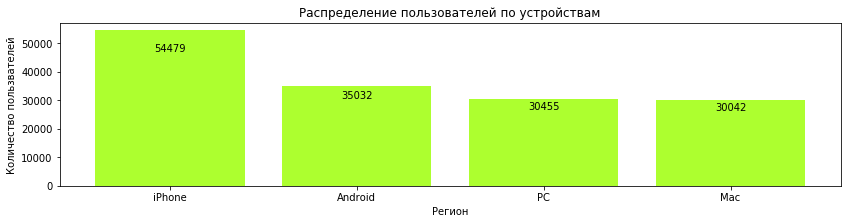

In [43]:
graph(profiles_device['user_id'],
      profiles_device['device'],
      'Регион',
      'Количество пользвателей',
      'Распределение пользователей по устройствам',
      'greenyellow',
      0)

- ***Найдем распределение платящих пользователей по устройствам.***

In [44]:
profiles_device_payer = profiles_sm_payer('device')
profiles_device_payer=profiles_device_payer.merge(profiles_device, how='left', on='device')
profiles_device_payer.columns=['device', 'count_payer', 'count_all']
profiles_device_payer['part_of_paying'] = (profiles_device_payer['count_payer'] / profiles_device_payer['count_all']).map(lambda x: '{:,.1%}'.format(x))
profiles_device_payer 

,device,count_payer,count_all,part_of_paying
0,iPhone,3382,54479,6.2%
1,Android,2050,35032,5.9%
2,Mac,1912,30042,6.4%
3,PC,1537,30455,5.0%


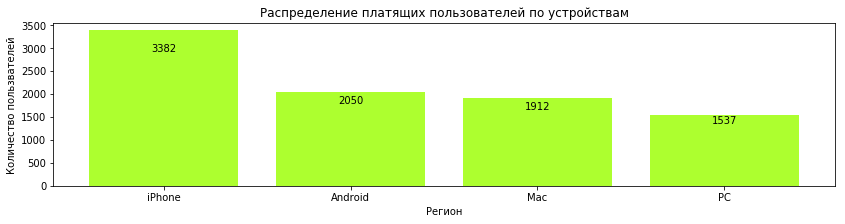

In [45]:
graph(profiles_device_payer['count_payer'],
      profiles_device_payer['device'],
      'Регион',
      'Количество пользвателей',
      'Распределение платящих пользователей по устройствам',
      'greenyellow',
       0)

#### Вывод

<div style="border:solid indigo 2px; padding: 20px">

**Используемые устройства**
- Самое популярное устройство - iPhone 54 479
- Далее идет Android  35 032.
- 3 и 4 места PC и Mac.

**Устройства платящих пользователей**    
- Первым идет iPhone 3382. 6,2% платящие
- Далее идет Android 2050. 5.9% платящие. Почти как у iPhone.
- 3 и 4 места Mac и PC. Платят 6,4% и 5,0% соответственно.
    
*Мас по количество пользователей на последнем месте, но по платящей части на 1м!*

### Рассмотрим каналы привлечения пользователей. Какие каналы приносят больше всего платящих пользователей.

In [46]:
profiles_channel = profiles_sm('channel')
profiles_channel

,channel,user_id
0,organic,56439
1,FaceBoom,29144
2,TipTop,19561
3,OppleCreativeMedia,8605
4,LeapBob,8553
5,WahooNetBanner,8553
6,RocketSuperAds,4448
7,MediaTornado,4364
8,YRabbit,4312
9,AdNonSense,3880


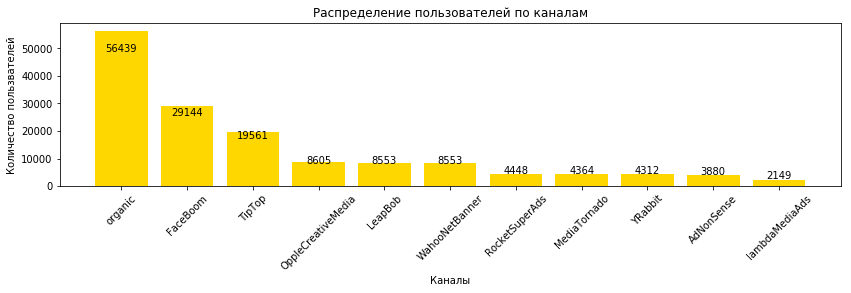

In [47]:
graph(profiles_channel['user_id'],
      profiles_channel['channel'],
      'Каналы',
      'Количество пользвателей',
      'Распределение пользователей по каналам',
      'gold',
       45)

- ***Найдем распределение платящих пользователей по каналам***

In [50]:
profiles_channel_payer = profiles_sm_payer('channel')
profiles_channel_payer=profiles_channel_payer.merge(profiles_channel,
                                                    how='left',
                                                    on='channel')
profiles_channel_payer.columns=['channel',
                                'count_payer',
                                'count_all']

profiles_channel_payer['part_of_paying'] = (
    (profiles_channel_payer['count_payer'] / profiles_channel_payer['count_all'])
    .map(lambda x: '{:,.1%}'.format(x))
)
profiles_channel_payer['part_of_all_paying'] = (
    (profiles_channel_payer['count_payer'] / profiles_channel_payer['count_all'].sum())
    .map(lambda x: '{:,.1%}'.format(x))
)
profiles_channel_payer

,channel,count_payer,count_all,part_of_paying,part_of_all_paying
0,FaceBoom,3557,29144,12.2%,2.4%
1,TipTop,1878,19561,9.6%,1.3%
2,organic,1160,56439,2.1%,0.8%
3,WahooNetBanner,453,8553,5.3%,0.3%
4,AdNonSense,440,3880,11.3%,0.3%
5,RocketSuperAds,352,4448,7.9%,0.2%
6,LeapBob,262,8553,3.1%,0.2%
7,OppleCreativeMedia,233,8605,2.7%,0.2%
8,lambdaMediaAds,225,2149,10.5%,0.1%
9,YRabbit,165,4312,3.8%,0.1%


- **Сортируем по процентам**
- Для этого создадим новый столбец, сортируем по нему, затем удалим его

In [51]:
profiles_channel_payer['new'] = profiles_channel_payer['part_of_paying'].str.strip('%').astype(float)

In [52]:
profiles_channel_payer = profiles_channel_payer.sort_values('new',ascending=False)
profiles_channel_payer = profiles_channel_payer.drop(columns = ['new'],axis = 1)
profiles_channel_payer

,channel,count_payer,count_all,part_of_paying,part_of_all_paying
0,FaceBoom,3557,29144,12.2%,2.4%
4,AdNonSense,440,3880,11.3%,0.3%
8,lambdaMediaAds,225,2149,10.5%,0.1%
1,TipTop,1878,19561,9.6%,1.3%
5,RocketSuperAds,352,4448,7.9%,0.2%
3,WahooNetBanner,453,8553,5.3%,0.3%
9,YRabbit,165,4312,3.8%,0.1%
10,MediaTornado,156,4364,3.6%,0.1%
6,LeapBob,262,8553,3.1%,0.2%
7,OppleCreativeMedia,233,8605,2.7%,0.2%


- **Построим график по количеству платящих пользователей из каналов**

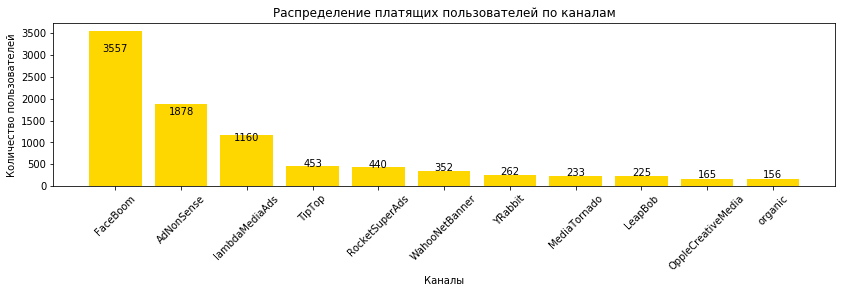

In [53]:
graph(profiles_channel_payer.sort_values('count_payer',ascending=False)['count_payer'],
      profiles_channel_payer['channel'],
      'Каналы',
      'Количество пользователей',
      'Распределение платящих пользователей по каналам',
      'gold',
       45)

- **Построим график по доле платящих пользователей из своего канала**

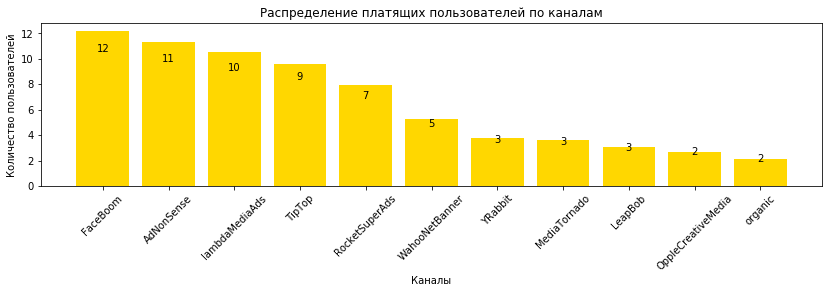

In [54]:
graph(profiles_channel_payer['part_of_paying'].str.strip('%').astype(float),
      profiles_channel_payer['channel'],
      'Каналы',
      'Количество пользователей',
      'Распределение платящих пользователей по каналам',
      'gold',
       45)

#### Вывод

<div style="border:solid indigo 2px; padding: 20px">

**Каналы привлечения пользователей**
- Лидер - органические пользователи 56439
- Далее идет FaceBoom  29144.
- 3е место у TipTop 19561.
- Остальные места имеют < 10 000 пользователей


**Распределение платящих пользователей по каналам**    
- Лидером оказался не organic, а FaceBoom 3557. 12.2% платящие
- Далее идет TipTop 1878. 9,6% платящие. 
- Только на 3м месте самый многочисленный канал organic с 1160 платящими пользователями, что составляет всего 2%
                            
**А вот распределение платящих пользоватлей по доле от каждого канала изменилось**
- Лидер  FaceBoom 12.2% платящие
- 2е место - AdNonSense 11,3%
- 3е место - lambdaMediaAds 10,5%  
- organic на последнем месте, хотя имеет самое большое количество пользователей        
                            

### Вывод

<div style="border:solid indigo 4px; padding: 20px">

**Определили момент и горизонт анализа:**

Минимальная дата анализа - 2019-05-01
Момент анализа - 2019-10-31
Горизонт анализа - 4
Максимальная дата анализа - 2019-10-28
    
***Рассмотрели профили пользователей по разным категориям с учетом платящих/неплатящих***

**Регион**


* Рейтинг всех пользователей и платящих совпали
  - Самый главный поставщик пользователей - United States 100 000. Платящих 6902 (6,9%)
  - Далее идет UK 17 575. Почти в 6 раз меньше, чем у United States. Платящих 700 (3,9%)
  - 3 и 4 места France и Germany. Платят 3,8% и 4,1% 
    
**Устройство**
  - Самое популярное устройство - iPhone 54 479. Платящих 3382 (6,2%)
  - Далее идет Android 35 032. Платящих 2050 (6,0%)
  - Далее места по популярности делят PC и Mac, а по платящим поменялись местами Платящих 6,4% (У Мака) и 5.0%
Мас по количество пользователей на последнем месте, но по платящей части на 1м!
    
**Канал** 
- Лидер по популярнсти - органические пользователи 56439
- Далее идет FaceBoom  29144.
- 3е место у TipTop 19561.
- Остальные места имеют < 10 000 пользователей

Рейтинг по платящим отличается
- Лидером оказался не organic, а FaceBoom 3557. 12% платящие
- Далее идет TipTop 1878. 9,6% платящие. 
- Только на 3м месте самый многочисленный канал organic с 1160 платящими пользователями, что составляет всего 2%   
                            
**Распределение платящих пользоватлей по доле от каждого канала изменилось**
- Лидер  FaceBoom 12.2% платящие
- 2е место - AdNonSense 11,3%
- 3е место - lambdaMediaAds 10,5%  
- organic на последнем месте, хотя имеет самое большое количество пользователей 
    
    
    
    


    
    
    
    

##  Маркетинг

### Общая сумма расходов на маркетинг

In [55]:
profiles.sample(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
69903,463988760124,2019-07-22 14:28:49,LeapBob,iPhone,Germany,2019-07-22,2019-07-01,False,0.21420
76140,505136189943,2019-06-27 14:36:11,OppleCreativeMedia,Mac,UK,2019-06-27,2019-06-01,False,0.25625
114052,760268120560,2019-08-23 23:39:10,organic,PC,France,2019-08-23,2019-08-01,False,0.00000
60014,398085302938,2019-08-21 12:13:15,organic,PC,United States,2019-08-21,2019-08-01,False,0.00000
128033,853972204882,2019-10-18 15:28:01,organic,PC,United States,2019-10-18,2019-10-01,False,0.00000


In [56]:
all_acquisition_cost = profiles['acquisition_cost'].sum()
print(f'Общая сумма расходов на маркетинг составила - {int(all_acquisition_cost)}')

Общая сумма расходов на маркетинг составила - 105497


### Общая сумма расходов на источник

- **Исключим из расчетов органических пользователей, тк в них вложений нет**

In [57]:
cost_sum_channel = (profiles
                    .query('channel != "organic"')
                    .groupby('channel')
                    .agg({'acquisition_cost':'sum', 'user_id':'count'})
                    .reset_index()
                    .sort_values('acquisition_cost', ascending=False)
                    .rename(columns={'acquisition_cost':'acquisition_cost_sum', 'user_id':'user_id_count'})
                   )
cost_sum_channel

,channel,acquisition_cost_sum,user_id_count
6,TipTop,54751.30,19561
1,FaceBoom,32445.60,29144
7,WahooNetBanner,5151.00,8553
0,AdNonSense,3911.25,3880
4,OppleCreativeMedia,2151.25,8605
5,RocketSuperAds,1833.00,4448
2,LeapBob,1797.60,8553
9,lambdaMediaAds,1557.60,2149
3,MediaTornado,954.48,4364
8,YRabbit,944.22,4312


- ***Добавим долю вложений***

In [58]:
cost_sum_channel['part_of_all_sum'] = (
    (cost_sum_channel['acquisition_cost_sum'] / all_acquisition_cost)
    .map(lambda x: '{:,.1%}'.format(x))
)

In [59]:
cost_sum_channel

,channel,acquisition_cost_sum,user_id_count,part_of_all_sum
6,TipTop,54751.30,19561,51.9%
1,FaceBoom,32445.60,29144,30.8%
7,WahooNetBanner,5151.00,8553,4.9%
0,AdNonSense,3911.25,3880,3.7%
4,OppleCreativeMedia,2151.25,8605,2.0%
5,RocketSuperAds,1833.00,4448,1.7%
2,LeapBob,1797.60,8553,1.7%
9,lambdaMediaAds,1557.60,2149,1.5%
3,MediaTornado,954.48,4364,0.9%
8,YRabbit,944.22,4312,0.9%


- ***Построим график для наглядности***

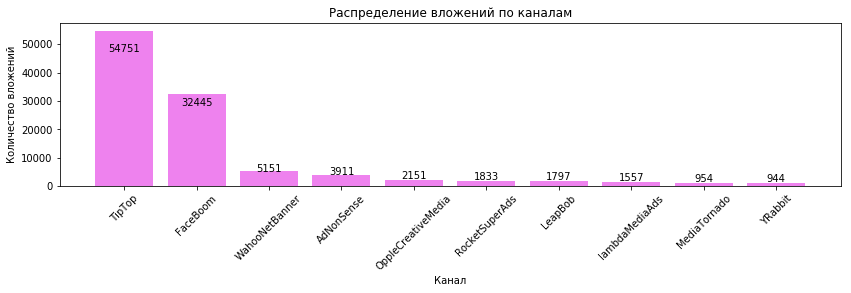

In [60]:
graph(cost_sum_channel['acquisition_cost_sum'],
      cost_sum_channel['channel'],
      'Канал',
      'Количество вложений',
      'Распределение вложений по каналам',
      'violet',
      45)

#### Вывод

<div style="border:solid indigo 1px; padding: 20px">

- **Общая сумма инвестиций составила 105 497**
- **51.9%** всех инвестиций пришлось на TipTop. Привел 19561 пользователей
- **30.8%** на FaceBoom. Зато привел больше пользователей, чем TipTop - 29144
- у остальных меньше 5%

### Общая сумма расходов во времени

In [61]:
cost_sum_time = (profiles
                    .query('channel != "organic"')
                    .groupby('dt')
                    .agg({'acquisition_cost':'sum'})
                 )
cost_sum_time.head()

,acquisition_cost
dt,
2019-05-01,304.820
2019-05-02,230.845
2019-05-03,263.070
2019-05-04,337.000
2019-05-05,319.905


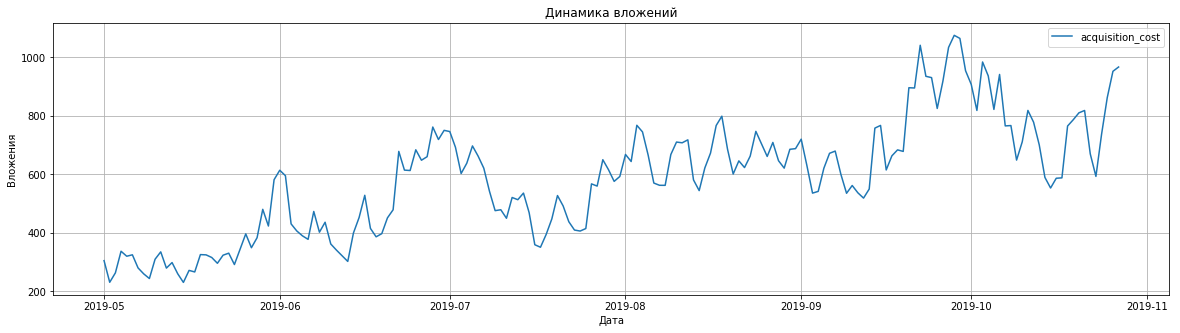

In [62]:
cost_sum_time.plot(grid=True, figsize=(20, 5))
plt.xlabel('Дата'),
plt.ylabel('Вложения'),
plt.title('Динамика вложений');

- **Динамика вложений в разрезе регионов**

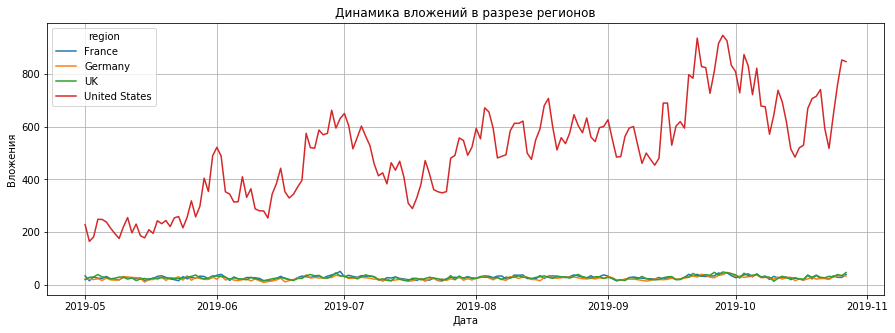

In [63]:
profiles.query('channel != "organic"').pivot_table(
    index='dt', 
    columns='region', 
    values='acquisition_cost',
    aggfunc='sum', 
).plot(figsize=(15, 5), grid=True)

plt.xlabel('Дата'),
plt.ylabel('Вложения'),
plt.title('Динамика вложений в разрезе регионов');

- **Динамика вложений в разрезе каналов**

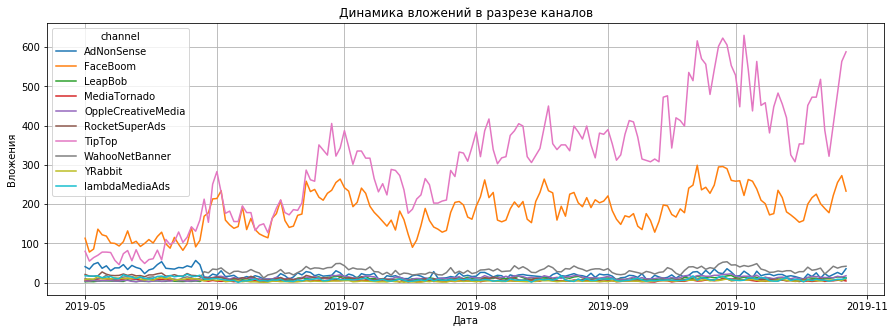

In [64]:
profiles.query('channel != "organic"').pivot_table(
    index='dt', 
    columns='channel', 
    values='acquisition_cost',
    aggfunc='sum', 
).plot(figsize=(15, 5), grid=True)

plt.xlabel('Дата'),
plt.ylabel('Вложения'),
plt.title('Динамика вложений в разрезе каналов');

#### Вывод

<div style="border:solid indigo 1px; padding: 20px">

- Скачки вложений наблюдаются в начале июня и июля
- С августа начинается рост инвестиций в маркетинг
- Пик инвестиций в конце сентября
- Лидер по вложениям - US
- Лидеры по каналам вложения - TipTop и FaceBoom. Оба канала из US.
- У остальных регионов и каналов аномалий во вложениях не наблюдается

### Средняя стоимость привлечения одного покупателя из каждого источника

In [65]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [66]:
avg_cost_per_channel = (profiles
                        .query('channel != "organic"')
                        .groupby('channel')
                        .agg({'acquisition_cost':'median'})
                        .sort_values('acquisition_cost', ascending=False)
                        .reset_index()
                        .rename(columns={'acquisition_cost': 'acquisition_cost_mean'})
                    )
avg_cost_per_channel

,channel,acquisition_cost_mean
0,TipTop,3.000000
1,FaceBoom,1.114667
2,AdNonSense,1.004348
3,lambdaMediaAds,0.733333
4,WahooNetBanner,0.600000
5,RocketSuperAds,0.404444
6,OppleCreativeMedia,0.250000
7,MediaTornado,0.220926
8,YRabbit,0.214286
9,LeapBob,0.210000


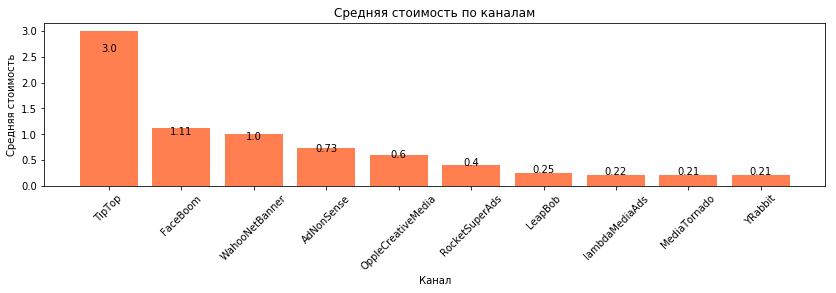

In [67]:
height = list(avg_cost_per_channel['acquisition_cost_mean'])
x_pos = list(cost_sum_channel['channel'])
plt.figure(figsize=(14,3))
plt.bar(x_pos, height, color='coral')
plt.xlabel('Канал')
plt.ylabel('Средняя стоимость')
plt.title('Средняя стоимость по каналам')
plt.xticks(rotation=45);

def autolabel(rects, labels=None, height_factor=1.01):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if labels is not None:
            try:
                label = labels[i]
            except (TypeError, KeyError):
                label = ' '
        else:
            label = round(float(height),2)
        ax.text(rect.get_x() + rect.get_width()/2., height_factor*height,
                '{}'.format(label),
                ha='center', va='bottom')

#bars = plt.bar(cities, values)
ax = plt.gca()
autolabel(ax.patches, height_factor=0.85)

- **каналы TipTop и FaceBoom лидеры по всем показателям, не считая количества пользователей (тут победили самопришедшие** **органические). Выясним, из каких регионов TipTop и FaceBoom**

In [68]:
(profiles
    .query('channel != "organic"')
    .groupby(['region','channel'])
    .agg({'user_id':'count'}) #.sort_values('user_id', ascending=False)
)

user_id
region        channel                    
France        AdNonSense             1366
              LeapBob                2988
              OppleCreativeMedia     2991
              WahooNetBanner         2971
              lambdaMediaAds          742
Germany       AdNonSense             1219
              LeapBob                2519
              OppleCreativeMedia     2562
              WahooNetBanner         2579
              lambdaMediaAds          649
UK            AdNonSense             1295
              LeapBob                3046
              OppleCreativeMedia     3052
              WahooNetBanner         3003
              lambdaMediaAds          758
United States FaceBoom              29144
              MediaTornado           4364
              RocketSuperAds         4448
              TipTop                19561
              YRabbit                4312

#### Вывод

<div style="border:solid indigo 1px; padding: 20px">

- Больше всего вложено через канал TipTop (3) из US
- Далее FaceBoom (1,11) из US
- AdNonSense (1,0)	
- Остальные каналы имеют < 1
                            

### Cредний CAC на одного пользователя для всего проекта

- ***Найдем размеры когорт и суммы вложений***

In [69]:
size_coh_sum = (profiles
    .query('channel != "organic"')
    .groupby(['dt'])
    .agg({'user_id':'count', 'acquisition_cost':'sum'})
    .rename(columns={'user_id': 'size_coh'})
)
size_coh_sum.head()

,size_coh,acquisition_cost
dt,,
2019-05-01,390,304.820
2019-05-02,323,230.845
2019-05-03,346,263.070
2019-05-04,457,337.000
2019-05-05,438,319.905


In [70]:
size_coh_sum['CAC_all'] = size_coh_sum['acquisition_cost'].sum() / size_coh_sum['size_coh'].sum()
size_coh_sum['CAC_all'][0]

1.1274813239427597

In [71]:
print(f'Cредний CAC на одного пользователя для всего проекта = {round(size_coh_sum["CAC_all"][0],2)}')

Cредний CAC на одного пользователя для всего проекта = 1.13


### Вывод

<div style="border:solid indigo 4px; padding: 20px">

**Инвестиции и средняя стоимость вложений**
- Общая сумма инвестиций составила **105 497**
- **51.9%** всех инвестиций пришлось на канал **TipTop**. Средняя стоимость привлечения здесь самая высокая - **3**
- **30.8%** всех инвестиций ушли на **FaceBoom** со средней стоимостью привлечения **1,11**
- у остальных каналов инвестиций меньше **5%**. Средняя стоимость привлечения меньше **1**
                                                                             
                                                                             
    
**Динамика вложений во времени**    
- Скачки вложений наблюдаются в начале июня и июля. Имеет место фактор сезона
- С августа начинается рост инвестиций
- Пик инвестиций в конце сентября
    
    
           
- *каналы TipTop и FaceBoom лидеры по всем показателям, не считая количества пользователей (тут победитель organic). Оба эти* *каналы из US*
    
    
    
- Cредний CAC на одного пользователя для всего проекта = 1.13

##  Окупаемость рекламы для привлечения пользователей

### Общая окупаемость рекламы

- ***Рассчитаем и визуализируем LTV и ROI, вызвав функции get_ltv() и plot_ltv_roi().***

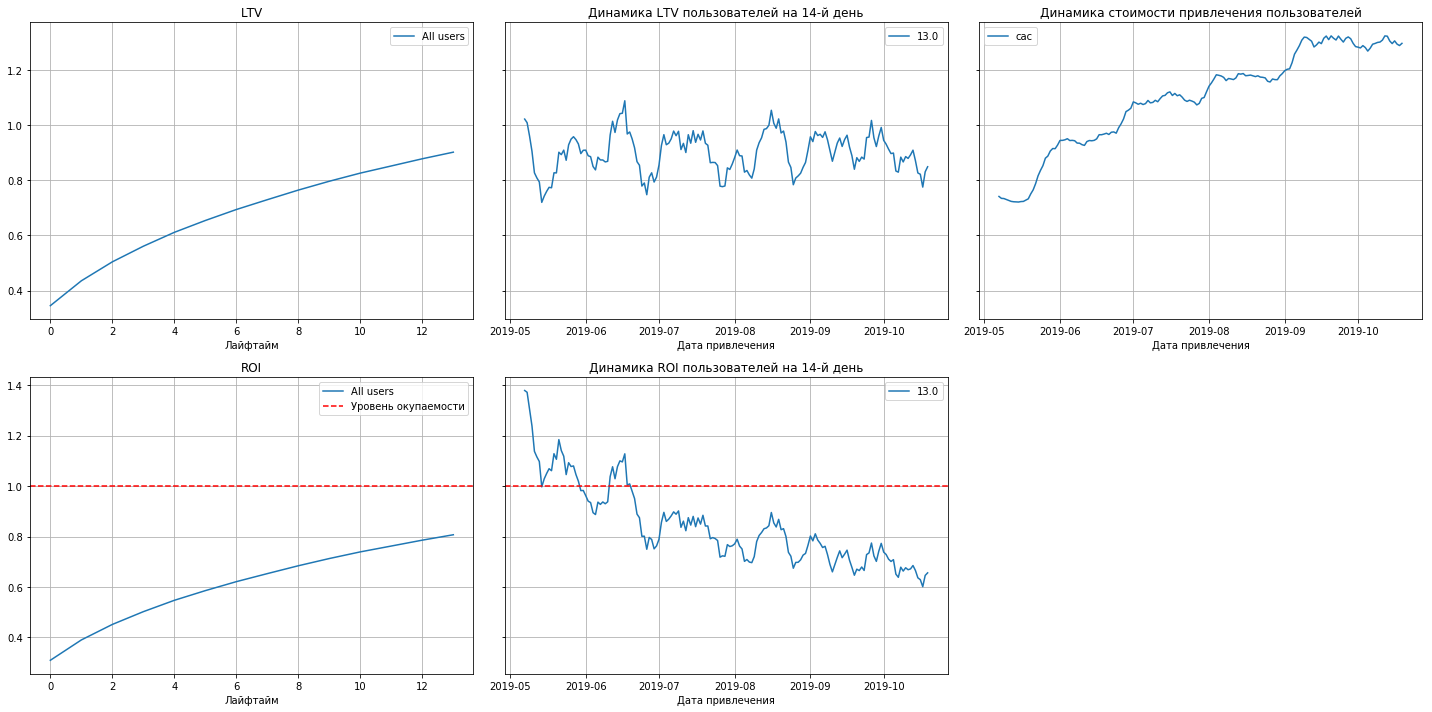

In [72]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

#### Вывод

<div style="border:solid indigo 1px; padding: 20px">

- Кривая LTV не снижается, значит момент и горизонт в норме
- Динамика LTV идет скачками, имеем постоянную прибыль
- САС постоянно увеличивается. Достигает пика в середине октября.
- **Реклама не окупается.** ROI в конце 14 дней — около 81%.
- Динамика ROI говорит о том, что окупаемость снижается
- **Чем больше делается вложений в маркетинг, тем меньше окупаемость**

### Окупаемость рекламы с разбивкой по странам

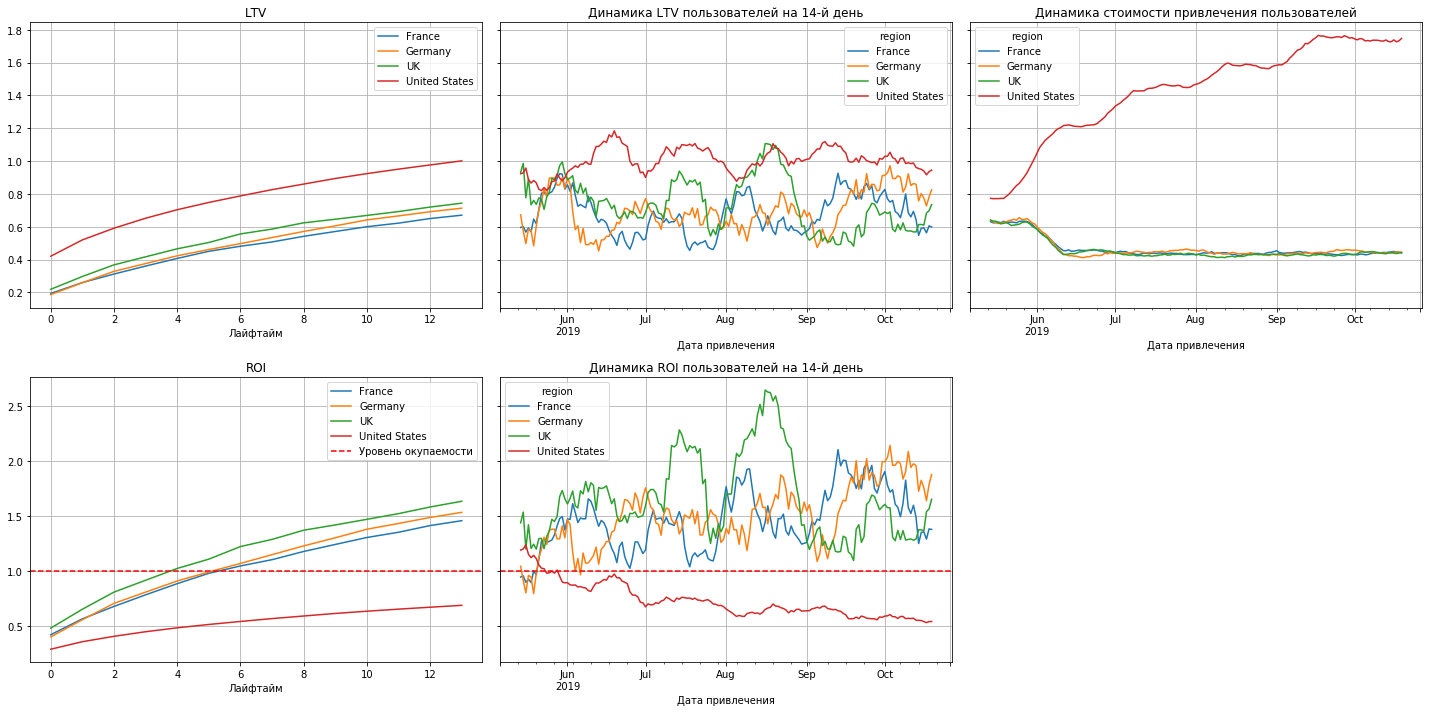

In [73]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

#### Вывод

<div style="border:solid indigo 1px; padding: 20px">

- С динамикой разбивки по странам не все так плохо.
- Динамика LTV идет скачками, имеем постоянную прибыль по всем регионам. У US LTV больше всех.
- **САС постоянно увеличивается только у US!!!** Каналы TipTop и FaceBoom лидеры и оба из US. Зачем так увеличивать рекламный бюджет? У остальных регионов САС стабильный
- Реклама не окупается только у US. ROI в конце двух недель — около 60%. Тогда как у остальных регионов - перевалило за 100% на 3й день. Лучшая окупаемость у UK.
- Динамика ROI говорит о том, что окупаемость снижается только у US.
- **Чем больше делает US вложений в маркетинг, тем меньше у них окупаемость**

### Окупаемость рекламы с разбивкой по рекламным каналам

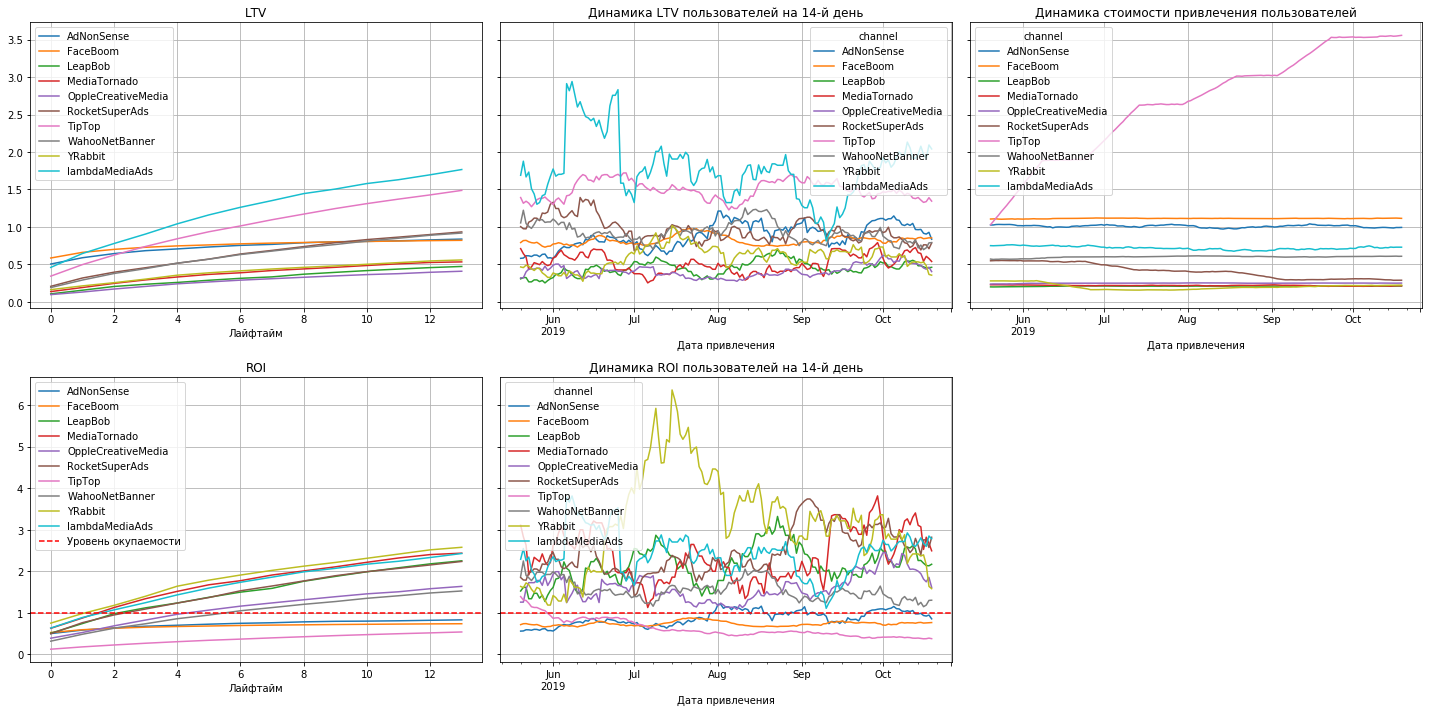

In [74]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=20
) 

#### Вывод

<div style="border:solid indigo 1px; padding: 20px">

- **Найден конкретный канал, через который идет огромное вложения в маркетинг - TipTop из US.** Остальные каналы имеют стабильную динамику, но 2й лидер из US все же обогнал остальных.
- Динамика LTV идет скачками, имеем постоянную прибыль по всем регионам. Лидер lambdaMediaAds из UK.
- **Худшее ROI как и ожидали у TipTop и FaceBoom из US.** Лучшая окупаемость у YRabbit, также из US. 


### Окупаемость рекламы с разбивкой по устройствам

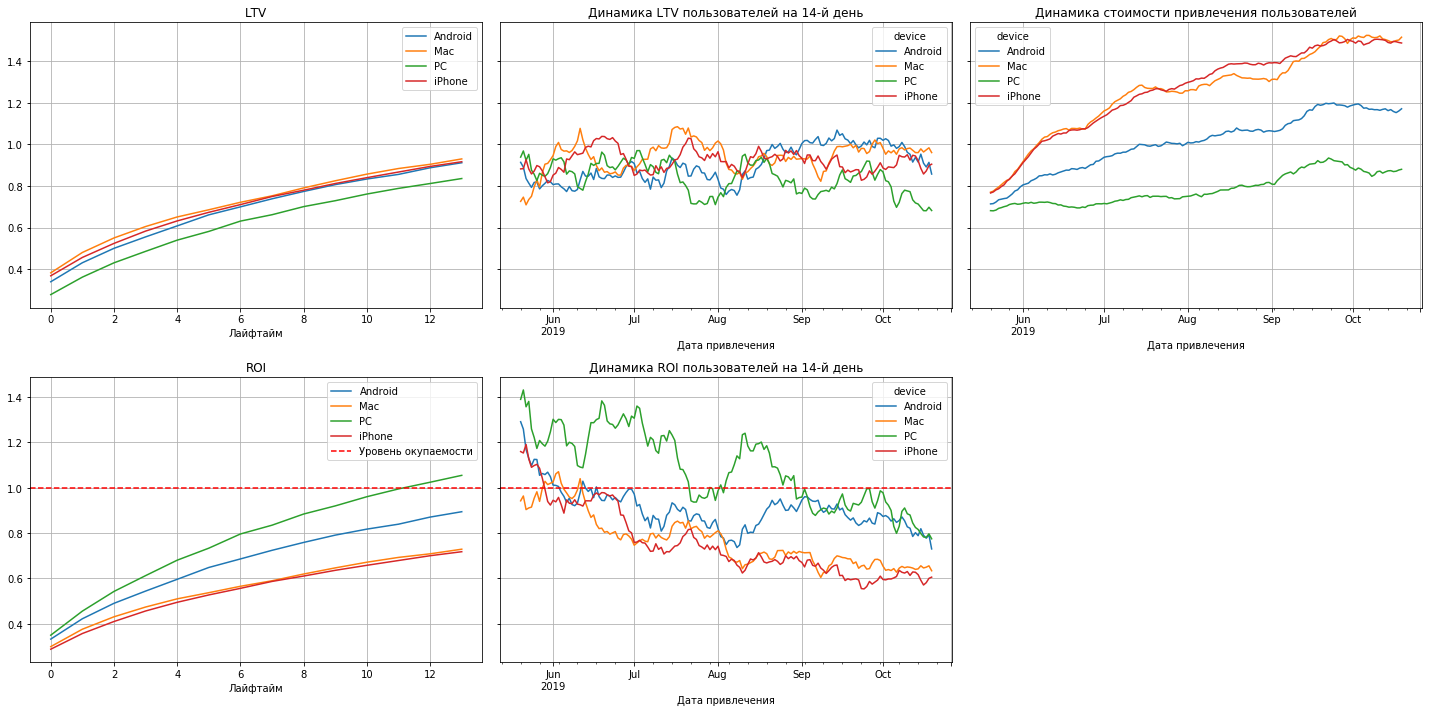

In [75]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=20
) 

#### Вывод

<div style="border:solid indigo 1px; padding: 20px">

- LTV у всех устройств на оном уровне, кроме РС - по-меньше
- Динамика LTV у всех в норме, все приносят прибыль
- У РС самые низкие вложения, а окупаемость выше всех, но не отличная
- **Все устройства к концу двух недель, кроме РС, не окупились**
    

### Конверсия

#### Конверсия с разбивкой по региону

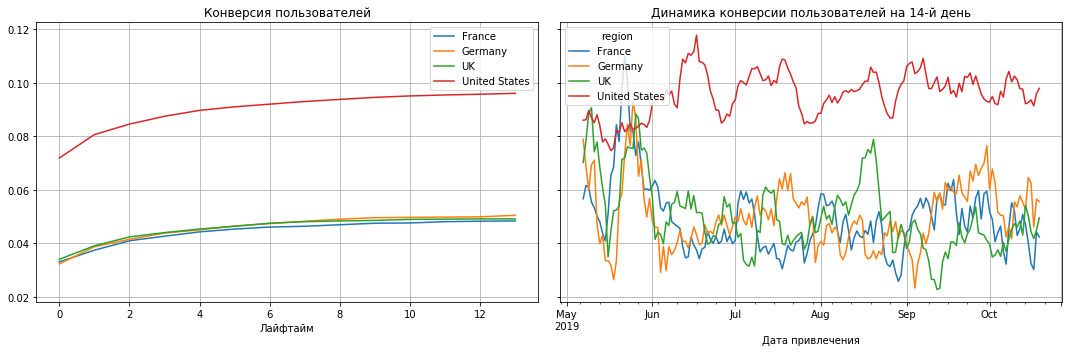

In [76]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

##### Вывод

<div style="border:solid indigo 1px; padding: 20px">

- US имеет отличную конверсию
- У остальных регионов конверсия примерно одинаковая. Germany чуть повыше остальных


#### Конверсия с разбивкой по устройству

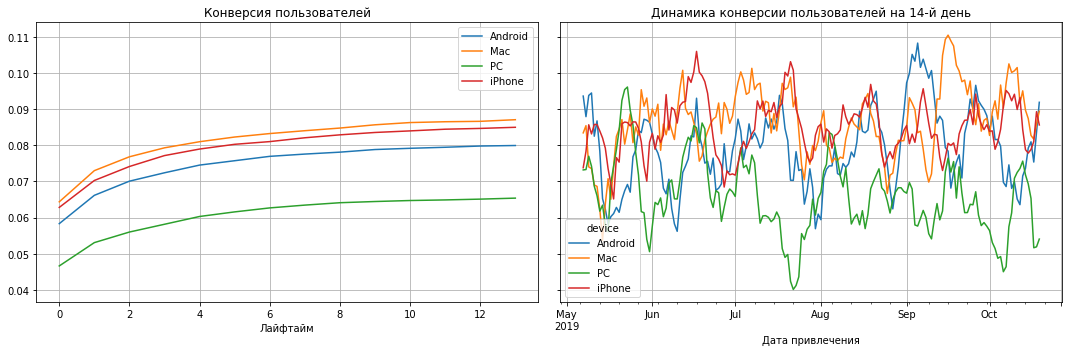

In [77]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

##### Вывод

<div style="border:solid indigo 1px; padding: 20px">

- Хуже всего конвертируются пользователи с РС, лучше с Mac.
- РС имеет плохое удержание и плохую конверсию

#### Конверсия с разбивкой по каналу

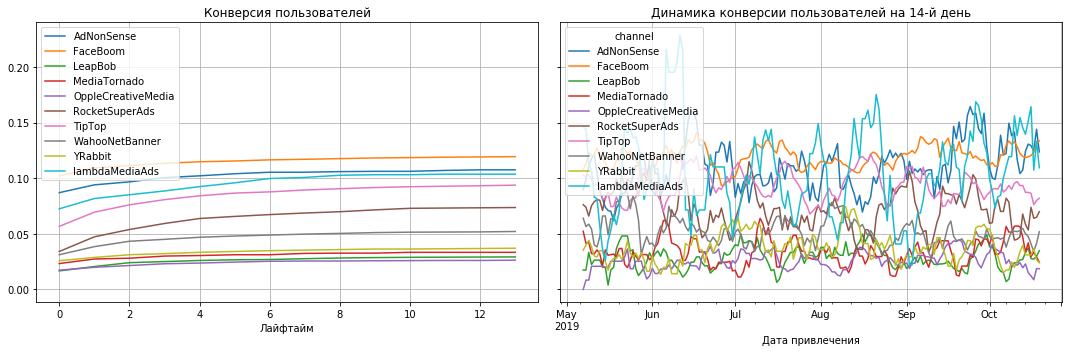

In [78]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

##### Вывод

<div style="border:solid indigo 1px; padding: 20px">

- Лучше всех конвертирует FaceBoom, ТipTop тоже выше среднего

#### Вывод

<div style="border:solid indigo 3px; padding: 20px">

- US имеет лучшую конверсию. У остальных регионов конверсия примерно одинаковая.
- Хуже всего конвертируются пользователи с РС, лучше с Mac.
- Лучше всех конвертирует FaceBoom из US. TipTop из US выше среднего

### Удержание

#### Удержание с разбивкой по региону

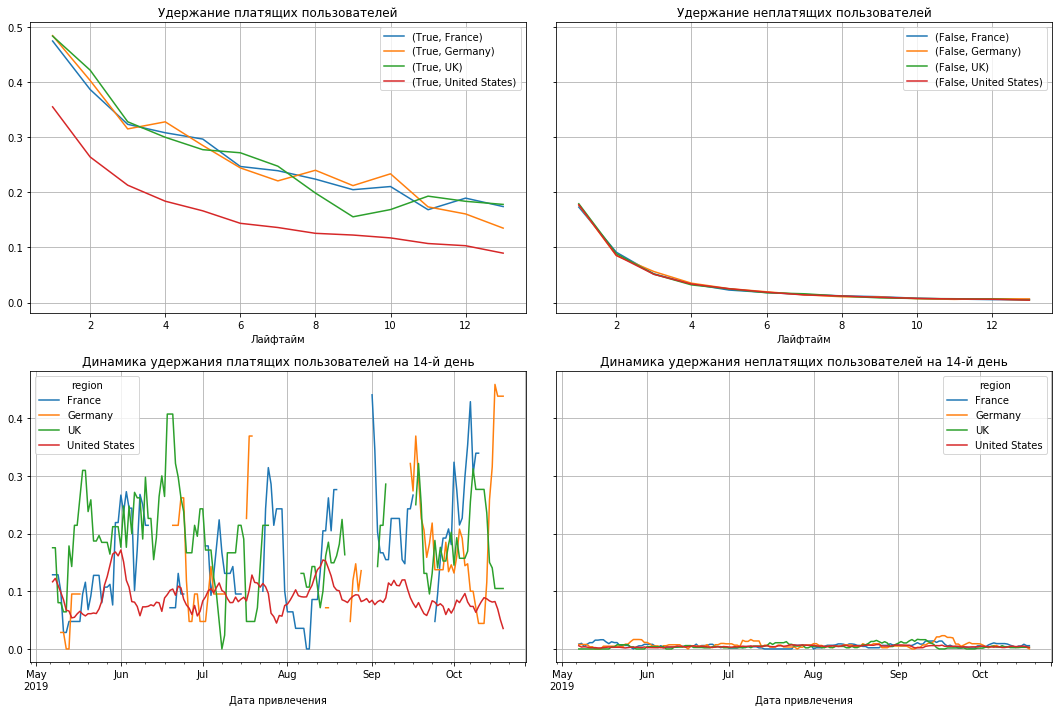

In [79]:
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel != "organic"'), visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

##### Вывод

<div style="border:solid indigo 1px; padding: 20px">

- Хуже всего с удержанием платящих пользователей у US. У остальных в целом одинаково
- Ситуация с неплатящими пользователями у всех регионов в целом схожа


#### Удержание с разбивкой по устройству

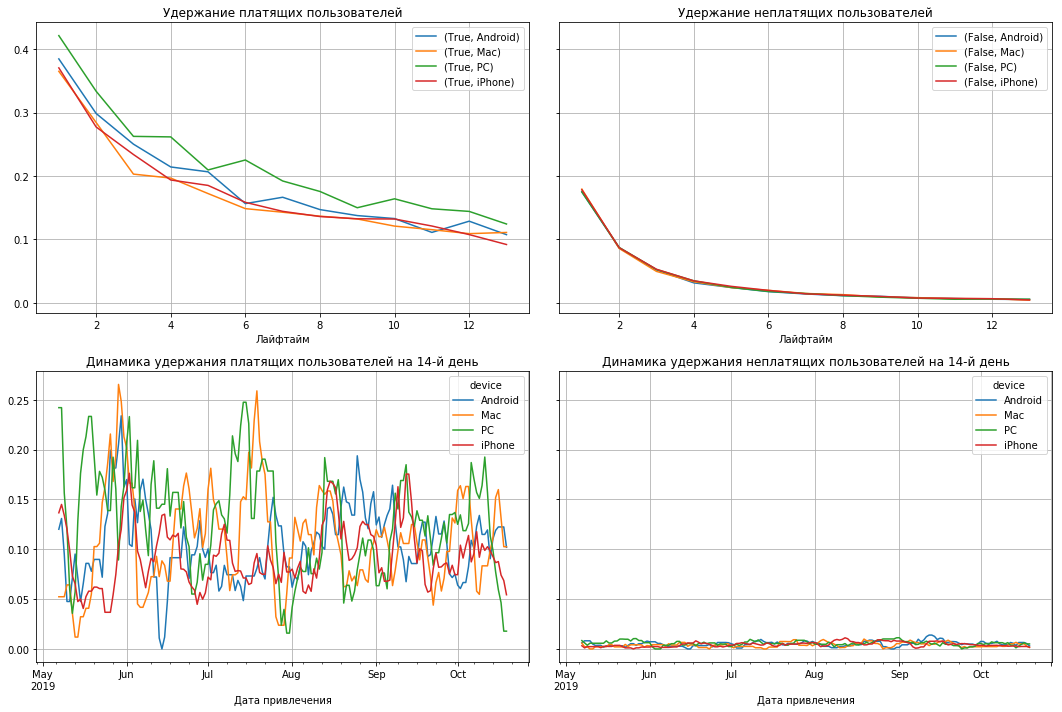

In [80]:
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel != "organic"'), visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

#####  Вывод

<div style="border:solid indigo 1px; padding: 20px">

- Лучше всего с удержанием платящих пользователей у РС. А конверсия была хуже всех.
- Ситуация с неплатящими пользователями у всех устройств в целом схожа


#### Удержание с разбивкой по каналу

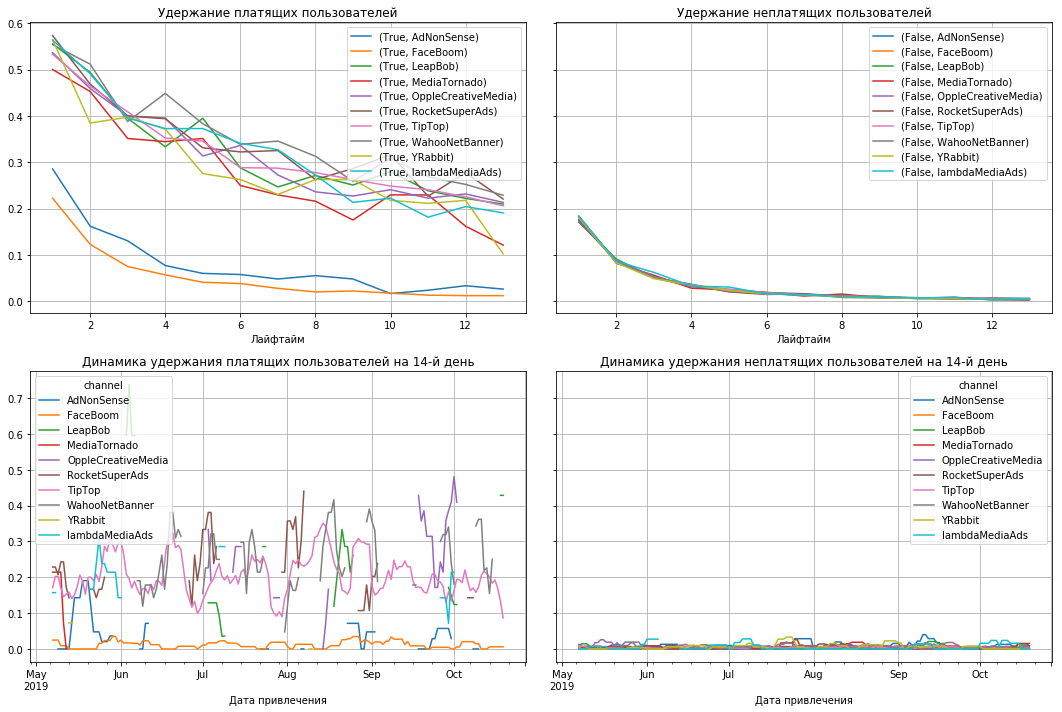

In [81]:
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel != "organic"'), visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

##### Вывод

<div style="border:solid indigo 1px; padding: 20px">

- **Хуже всего с удержанием платящих пользователей у FaceBoom.**
- **TipTop в нормальном положении, удержание в норме, как у всех. Вкладывают в него огромные деньги, стоит ли?**
- Органические - вторые снизу, в них ничего и не вкладывают
- Ситуация с неплатящими пользователями у всех каналов в целом схожа


### Вывод

<div style="border:solid indigo 4px; padding: 20px">

**Общая окупаемость рекламы**
- LTV нам говорит, что есть постоянная прибыль.
- Но реклама не окупается. ROI в конце 14 дней — около 95%.
- Динамика ROI говорит о том, что окупаемость снижается
- САС постоянно увеличивается
- Получается чем больше делается вложений в маркетинг, тем меньше окупаемость. Это проблема!
    
    
**Окупаемость рекламы с разбивкой по странам**
- **САС постоянно увеличивается только у US!!!** Каналы TipTop и FaceBoom лидеры по пользователями и оба из US. Зачем так увеличивать рекламный бюджет? У остальных регионов САС стабильный
- Реклама не окупается только у US. ROI в конце двух недель — около 60%. Тогда как у остальных регионов - перевалило за 100% на 3й день. Лучшая окупаемость у UK.
- Динамика ROI говорит о том, что окупаемость снижается только у US.
- **Чем больше делает US вложений в маркетинг, тем меньше у них окупаемость**
- **Проблема в US**
    

**Окупаемость рекламы с разбивкой по рекламным каналам**
- Найден конкретный канал, через который идет **огромное вложения в маркетинг - TipTop из US**. Остальные каналы имеют стабильную динамику, но 2й лидер из US все же обогнал остальных.
- Динамика LTV идет скачками, имеем постоянную прибыль по всем регионам. Лидер lambdaMediaAds из UK.
- Худшее ROI, как и ожидали, у TipTop и FaceBoom из US. Лучшая окупаемость у YRabbit, также из US.
    
**Окупаемость рекламы с разбивкой по устройствам**
    
- LTV у всех устройств на оном уровне, кроме РС - по-меньше
- Динамика LTV у всех в норме, все приносят прибыль
- У РС самые низкие вложения, а окупаемость выше всех, но не отличная
- **Все устройства к концу двух недель, кроме РС, не окупились**    
    
    
**Конверсия и удержание**    
- US имеет отличную конверсию, лучше всех. У остальных регионов конверсия примерно одинаковая
- Хуже всего конвертируются пользователи с РС, лучше с Mac.    
- **Лучше всех конвертирует пользователи с канала FaceBoom из US,что и влияет на весь регион в целом.** ТipTop тоже выше среднего
- Хуже всего с удержанием платящих пользователей у US. **US имеет лучшую конверсию, но худшее удержание.** У остальных в целом одинаково.   
- Лучше всего с удержанием платящих пользователей у РС. А конверсия была хуже всех. У остальных в целом удержание одинаково   
- **Хуже всего с удержанием платящих пользователей у FaceBoom, что и влияет на весь регион в целом**. TipTop в нормальном положении, удержание в норме. Органические - вторые снизу, в них ничего и не вкладывают. У остальных в целом одинаковое удержание    

## Причина неэффективности привлечения пользователей

- **Имеем проблему с двумя каналами из US  FaceBoom и ТipTop, которые приводят подавляющее количество пользователей**
- *Посмотрим на распределение вложений и количества привлеченных пользователей, найдем доли*
- *Не будем учитывать органических пользователей, тк на них не делаем никаких вложений*

In [82]:
cost_sum_channel_without_organic = cost_sum_channel.query('channel != "organic"')
user_count_without_organic = cost_sum_channel_without_organic['user_id_count'].sum()
cost_sum_channel_without_organic['part_of_all_user'] =(
    (cost_sum_channel_without_organic['user_id_count'] / user_count_without_organic)
    .map(lambda x: '{:,.1%}'.format(x))
)
cost_sum_channel_without_organic

,channel,acquisition_cost_sum,user_id_count,part_of_all_sum,part_of_all_user
6,TipTop,54751.30,19561,51.9%,20.9%
1,FaceBoom,32445.60,29144,30.8%,31.1%
7,WahooNetBanner,5151.00,8553,4.9%,9.1%
0,AdNonSense,3911.25,3880,3.7%,4.1%
4,OppleCreativeMedia,2151.25,8605,2.0%,9.2%
5,RocketSuperAds,1833.00,4448,1.7%,4.8%
2,LeapBob,1797.60,8553,1.7%,9.1%
9,lambdaMediaAds,1557.60,2149,1.5%,2.3%
3,MediaTornado,954.48,4364,0.9%,4.7%
8,YRabbit,944.22,4312,0.9%,4.6%


### Вывод

<div style="border:solid green 4px; padding: 20px">

**Причина убытков компании при огромных вложениях**
- TipTop - 2й по количеству привлеченных пользователей (21%), но в него вложено больше половины всех вложений. 
- FaceBoom приводит самое большое количество пользователей (31%), имеет лучшую конверсию, но низкое удержание. Пользователи не возвращаются, сделав покупку. **Пользователей нужно привлечь!**
    
<font color="darkviolet">**Рекомендация отделу маркетинга:**</font> - *Необходимо улучшить удержание канала FaceBoom, путем перевода вложений с TipTop*
    
    

**От общей массы выделяется устройства РС**
- У РС самые низкие вложения, а окупаемость выше всех.
- К концу двух недель окупились только пользователи с РС.   
- Но его пользователи конвертируются хуже всех.
- Удержание платящих лучше всех у РС
- Получается пользователи заходят через РС, возвращаются часто, но мало покупают. Возможно есть техническая проблема с покупкой у пользователей.
    
<font color="darkviolet">**Рекомендация отделу маркетинга:**</font> 
                - *Проверить наличие технических проблем с покупкой у пользователей устройства РС.*    
        

    
**Каналы Европы**    
- Проблема с удержанием у канала AdNonSense во всех регионах его присутствия, а конверсия у канала лучшая среди каналов Европы. Только по этому каналу Европы реклама не окупается
    
<font color="darkviolet">**Рекомендация отделу маркетинга:**</font> 
                - *Увеличить вложения в канал AdNonSense*
    

**Обо всем**
- UK на 2м месте по окупаемости рекламы. Имеет отличную конверсию.     
- Самое высокое LTV у lambdaMediaAds из UK. Окупаемость вложений через канал уже на 2й день! 
- Лучшая окупаемость у YRabbit из US.
- Хорошо конвертируются пользователи французского канала lambdaMediaAds
- Конверсия после US лучше у Germany.
